# The Pythagorean three body problem (Errebersiblea)

<ul id="top">
<li><a href="#Loading-packages-and-functions"> 
             Loading packages and functions</a></li>
    
<li><a href="#Definition-of-the-three-body-problem"> 
             Definition of the three-body problem</a></li>  

<li><a href="#IRKGL16-Integration">
             IRKGL16-Integration</a></li>

<li><a href="#Integration-with-NEW-adaptive-stepsize-(EDA-absolutoak!!)">
             Integration with NEW-adaptive stepsize-(EDA absolutoak!!)</a></li>

 <li><a href="#Integration-Time-Renormalization">
             Integration-Time-Renormalization</a></li>
             
<li><a href="#Comparison">
               Comparison</a></li>

</ul> 

## Loading packages and functions

In [1]:
using LinearAlgebra
using Plots, LaTeXStrings
using DataFrames
using OrdinaryDiffEq
using IRKGaussLegendre

In [2]:
PATH_DATA="./Data/"

PATH_SRC="../../src/simd/"
include(string(PATH_SRC,"IRKGL_SIMD.jl"))
using .IRKGL_SIMD   

PATH_SRC="../../src/simd-new/"
include(string(PATH_SRC,"IRKGL_SIMD_NEW.jl"))
using .IRKGL_SIMD_NEW   

PATH_SRC="../../src/seq/"
include(string(PATH_SRC,"IRKGL_SEQ.jl"))
using .IRKGL_SEQ  

setprecision(BigFloat, 256)

256

##### <a href="#top">Back to the top</a>

## Definition of the three-body problem

In [3]:
PATH_ODES="../../ODEProblems/"

include(string(PATH_ODES,"InitialPythagorean3BP.jl"))
include(string(PATH_ODES,"Nbody3REL.jl"))
include(string(PATH_ODES,"Nbody.jl"))

NbodyODE! (generic function with 2 methods)

### Initial value problem: Pythagorean 3 body problem

In [4]:
t0=0.
tf=63.
tspan= (t0,tf)
tspanB= (BigFloat(t0),BigFloat(tf))

u0rel, Gm_B, bodylist = InitialPythagorean3BPREL(BigFloat)
N = length(Gm_B)
prob1 = ODEProblem(NbodyODE3REL!, u0rel ,tspanB , Gm_B)


u0_B, Gm_B, bodylist = InitialPythagorean3BP(BigFloat)
N = length(Gm_B)

# Egoera aldagai bat gehitu dut: tau edo t integrazioan kalkulatzeko
u0R=fill(zero(eltype(u0_B)),(3,N+1,2))
u0R[1:3,1:N,1:2].=u0_B[:,:,:];

prob2 = ODEProblem(NbodyODEer2!, u0R ,tspanB , Gm_B);

 <a href="#top">Back to the top</a>

## IRKGL16-Integration

In [5]:
tol= 1e-18
sol1=solve(prob1,IRKGL16(initial_interp=false), adaptive=true, reltol=tol, abstol=tol)

steps=sol1.t[2:end]-sol1.t[1:end-1]
nsteps=length(steps)

@show sol1.retcode, nsteps

[sol1.stats.nf sol1.stats.naccept]

(sol1.retcode, nsteps) = (SciMLBase.ReturnCode.Success, 2427)


1×2 Matrix{Int64}:
 955891  2427

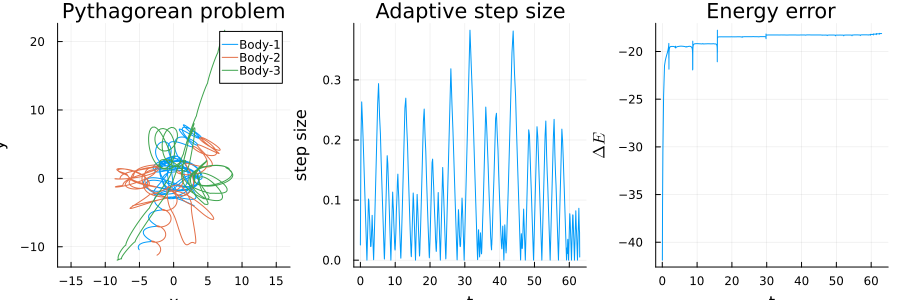

In [20]:
bodylist = ["Body-1", "Body-2", "Body-3"]
pl = plot(title="Pythagorean problem",xlabel="x", ylabel="y",aspect_ratio=1)

out=similar(u0rel)
ulist =[coord_bar(out,u) for u in sol1.u]
tlist = sol1.t[1:end]

for j = 1:3
 xlist  = map(u->u[1,j,1], ulist)
 ylist  = map(u->u[2,j,1], ulist)
 pl = plot!(xlist,ylist, label = bodylist[j])   
end  

pl2=plot(xlabel="t", ylabel="step size",title="Adaptive step size")
steps=sol1.t[2:end]-sol1.t[1:end-1]
pl2=plot!(sol1.t[1:end-1],steps,label="")


E0=NbodyEnergy3REL(u0rel,Gm_B)
ΔE1 = map(x->NbodyEnergy3REL(BigFloat.(x),Gm_B), sol1.u)./E0.-1
pl3=plot(title="Energy error", xlabel="t", ylabel=L"\Delta E")
pl3=plot!(sol1.t,log10.(abs.(ΔE1)), label="")

plot(pl,pl2,pl3, layout=(1,3), size=(900,300))

 <a href="#top">Back to the top</a>

## Integration-with-NEW-adaptive-stepsize (EDA absolutoak!!)

In [27]:
m=1
alg=IRKGL_seq(m=m, initial_extrap=0, Dtau=0.46)
sol2=solve(prob2, alg, adaptive=true, maxiters=1000)

steps=sol2.t[2:end]-sol2.t[1:end-1]
nsteps=length(steps)

@show sol2.retcode,nsteps, sol2.u[end][1,N+1,1]

[sol2.stats.nf sol2.stats.naccept]

(sol2.retcode, nsteps, (sol2.u[end])[1, N + 1, 1]) = (SciMLBase.ReturnCode.Success, 2417, 1111.652277105402445678928697357434162960985644351118538739782521826100254650915)


1×2 Matrix{Int64}:
 1227080  2417

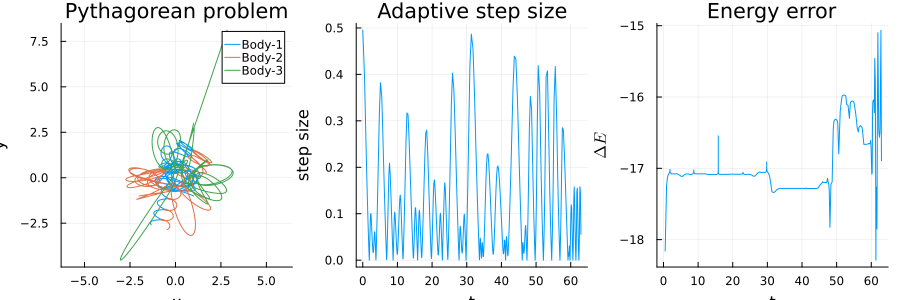

In [28]:
bodylist = ["Body-1", "Body-2", "Body-3"]
pl = plot(title="Pythagorean problem",xlabel="x", ylabel="y",aspect_ratio=1)


ulist =[u for u in sol2.u]
tlist = sol2.t[1:end]

for j = 1:3
 xlist  = map(u->u[1,j,1], ulist)
 ylist  = map(u->u[2,j,1], ulist)
 pl = plot!(xlist,ylist, label = bodylist[j])   
end 

pl2=plot(xlabel="t", ylabel="step size",title="Adaptive step size")
steps =sol2.t[2:end]-sol2.t[1:end-1]
pl2=plot!(sol2.t[1:end-1],steps, label="")

#u0Big=BigFloat.(u0)
#GmBig=BigFloat.(Gm)

E0=NbodyEnergy(u0_B, Gm_B)
ΔE2 = map(x->NbodyEnergy(BigFloat.(x),Gm_B), sol2.u)./E0.-1
pl3=plot(title="Energy error", xlabel="t", ylabel=L"\Delta E")
pl3=plot!(sol2.t,log10.(abs.(ΔE2)), label="")

plot(pl,pl2, pl3, layout=(1,3), size=(900,300))

 <a href="#top">Back to the top</a>

## Integration-Time-Renormalization

In [29]:
tau0=0.
TauF=sol2.u[end][1,N+1,1]
tauspan_B= (BigFloat(tau0),BigFloat(TauF))
prob3 = ODEProblem(NbodyODERen!, u0R,tauspan_B, Gm_B);

In [30]:
m=1
alg=IRKGL_seq(m=m, initial_extrap=0)

sol3=solve(prob3,alg, dt=BigFloat(0.46), adaptive=false, maxiters=1000)

steps=sol3.t[2:end]-sol3.t[1:end-1]
nsteps=length(steps)

tR=[u[1,N+1,1] for u in sol3.u];

@show sol3.retcode,nsteps

[sol3.stats.nf sol3.stats.naccept]

(sol3.retcode, nsteps) = (SciMLBase.ReturnCode.Success, 2417)


1×2 Matrix{Int64}:
 863360  2417

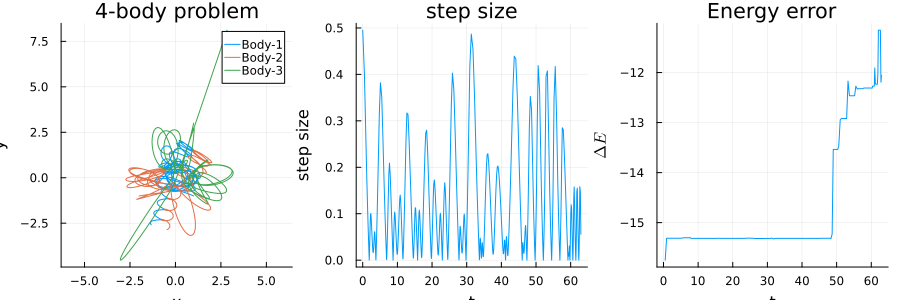

In [31]:
pl = plot(title="4-body problem", 
            xlabel="x", ylabel="y",  aspect_ratio=1)

for j = 1:N
    x  = [u[1,j,1] for u in sol3.u]
    y  = [u[2,j,1] for u in sol3.u] 
    pl = plot!(x,y, label=bodylist[j]) 
end 

pl2=plot(xlabel="t", ylabel="step size",title="step size")
steps =tR[2:end]-tR[1:end-1]
pl2=plot!(tR[1:end-1],steps, label="")


E0=NbodyEnergy(u0_B, Gm_B)
ΔE3 = map(x->NbodyEnergy(BigFloat.(x),Gm_B), sol3.u)./E0.-1
pl3=plot(title="Energy error", xlabel="t", ylabel=L"\Delta E")
pl3=plot!(tR,log10.(abs.(ΔE3)), label="")

plot(pl,pl2, pl3, layout=(1,3), size=(900,300))

 <a href="#top">Back to the top</a>

## Comparison

### Energy error

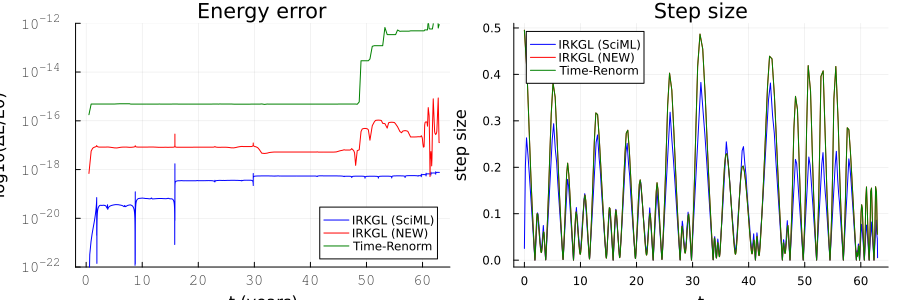

In [32]:
E0=NbodyEnergy(u0_B, Gm_B)
yrange=(1e-22,1e-12)
ΔE1 = map(x->NbodyEnergy3REL(BigFloat.(x),Gm_B), sol1.u)./E0.-1
ΔE2 = map(x->NbodyEnergy(BigFloat.(x),Gm_B), sol2.u)./E0.-1
ΔE3 = map(x->NbodyEnergy(BigFloat.(x),Gm_B), sol3.u)./E0.-1

pl1=plot(title="Energy error", xlabel="t (years)", ylabel="log10(ΔE/E0)", 
     yscale=:log10, ylims=yrange,
     xtickfont = font(8, "Courier"),
     ytickfont = font(8, "Courier"),
     legend=:bottomright)

pl1=plot!(sol1.t,abs.(ΔE1),label="IRKGL (SciML)", color="blue")
pl1=plot!(sol2.t,abs.(ΔE2),label="IRKGL (NEW)", color="red")
pl1=plot!(tR,abs.(ΔE3), label="Time-Renorm", color="green")

pl2=plot(xlabel="t", ylabel="step size",title="Step size",legend=:topleft)
steps1 =sol1.t[2:end]-sol1.t[1:end-1]
pl2=plot!(sol1.t[1:end-1],steps1,label="IRKGL (SciML)", color="blue")
steps2 =sol2.t[2:end]-sol2.t[1:end-1]
pl2=plot!(sol2.t[1:end-1],steps2,label="IRKGL (NEW)", color="red")
steps3 =tR[2:end]-tR[1:end-1]
pl3=plot!(tR[1:end-1],steps3,label="Time-Renorm", color="green")


plot(pl1,pl2, layout=(1,2), size=(900,300))

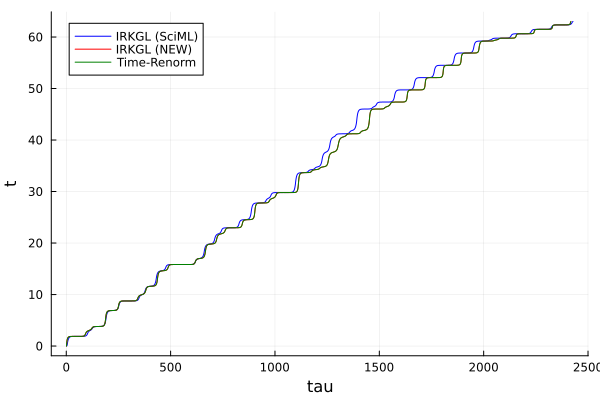

In [33]:
# t-ren taurekiko eboluzioa aztertzeko grafikoa
# ( kontutan hartuta, tau urrats kopuruaren proportzionala dela)
plot(sol1.t, xlabel="tau", ylabel="t", label="IRKGL (SciML)", color="blue")
plot!(sol2.t, label="IRKGL (NEW)", color="red")
plot!(tR, label="Time-Renorm", color="green")

### Summary

In [34]:
summary=DataFrame()
summary.Steps_SciML=[sol1.stats.naccept]
summary.Steps_New=[sol2.stats.naccept]
summary.Steps_Reg=[sol3.stats.naccept]
summary.it_SciML=[sol1.stats.nf/sol1.stats.naccept/8]
summary.it_New=[sol2.stats.nf/sol2.stats.naccept/8]
summary.it_Reg=[sol3.stats.nf/sol3.stats.naccept/8]
show(summary)

1×6 DataFrame
 Row │ Steps_SciML  Steps_New  Steps_Reg  it_SciML  it_New   it_Reg  
     │ Int64        Int64      Int64      Float64   Float64  Float64 
─────┼───────────────────────────────────────────────────────────────
   1 │        2427       2417       2417   49.2321  63.4609  44.6504